# Model Training

In [1]:
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')
from utils.machine_learning import DataPreprocess, ModelTraining, MetricsVisualizations

In [2]:
preprocess = DataPreprocess()
trainer = ModelTraining()

# Data

In [3]:
df = pd.read_csv("./Data/model_training_dataset.csv")

In [4]:
df.head()

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,distance_to_city_center
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,4.758574
1,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,11.837218
2,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,5.066276
3,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,10.723607
4,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,4.539056


# Preprocessing the Data

### For the preprocess step, the data will be divided into a train and test split. Also, onehot encoding will be performed on the categorical columns of the datasets, and the numerical columns will be transformed using the log and cubic transformations, then they will be scaled using the Robust Scaler in reason of the outliers and because the `latitude` and `longitude` columns won't go through the transformation step. The preprocessor will be saved on the **Artifacts** folder.

In [5]:
X_train, X_test, y_train, y_test = preprocess.preprocess_data(df, test_size=0.3, target_name="price")

# Modeling

### For the modeling phase, four models will be used: **Ridge**, **Lasso**, **Random Forest** and **Gradient Boosting**. These models were chosen because of the non-linear relationship between the majority of the numerical columns and the target `price`, so using Linear Regression wouldn't make any sense in this case.

### After the models are trained and tested, they will be evaluated in terms of the metrics MAE and RMSE, to see the error of the models in the same unit as the prices, and R² to see how much of the variability of the data the model can explain, along with visualization of the residuals. Also, the top 5 most important features of each model will be plotted in relation to the increase in MAE, to check if any transformation, or if the feature created, was successful or not.

### To train the models, a repo in DagsHub will be used, along with MLflow to keep track of all information about the models.

## Model Training

In [6]:
model_report = trainer.initiate_model_trainer((X_train, y_train, X_test, y_test), "LH_CD_Vitor-Cunha")

Successfully registered model 'Ridge - LH_CD_Vitor-Cunha'.
2024/02/22 03:33:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Ridge - LH_CD_Vitor-Cunha, version 1
Created version '1' of model 'Ridge - LH_CD_Vitor-Cunha'.
Successfully registered model 'Lasso - LH_CD_Vitor-Cunha'.
2024/02/22 03:34:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Lasso - LH_CD_Vitor-Cunha, version 1
Created version '1' of model 'Lasso - LH_CD_Vitor-Cunha'.
Successfully registered model 'Random Forest - LH_CD_Vitor-Cunha'.
2024/02/22 05:41:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - LH_CD_Vitor-Cunha, version 1
Created version '1' of model 'Random Forest - LH_CD_Vitor-Cunha'.
Successfully registered model 'Gradient Boosting - LH_CD_Vitor-Cunha'.
2024/02/

## Model Performance

In [15]:
metrics = MetricsVisualizations(model_report)

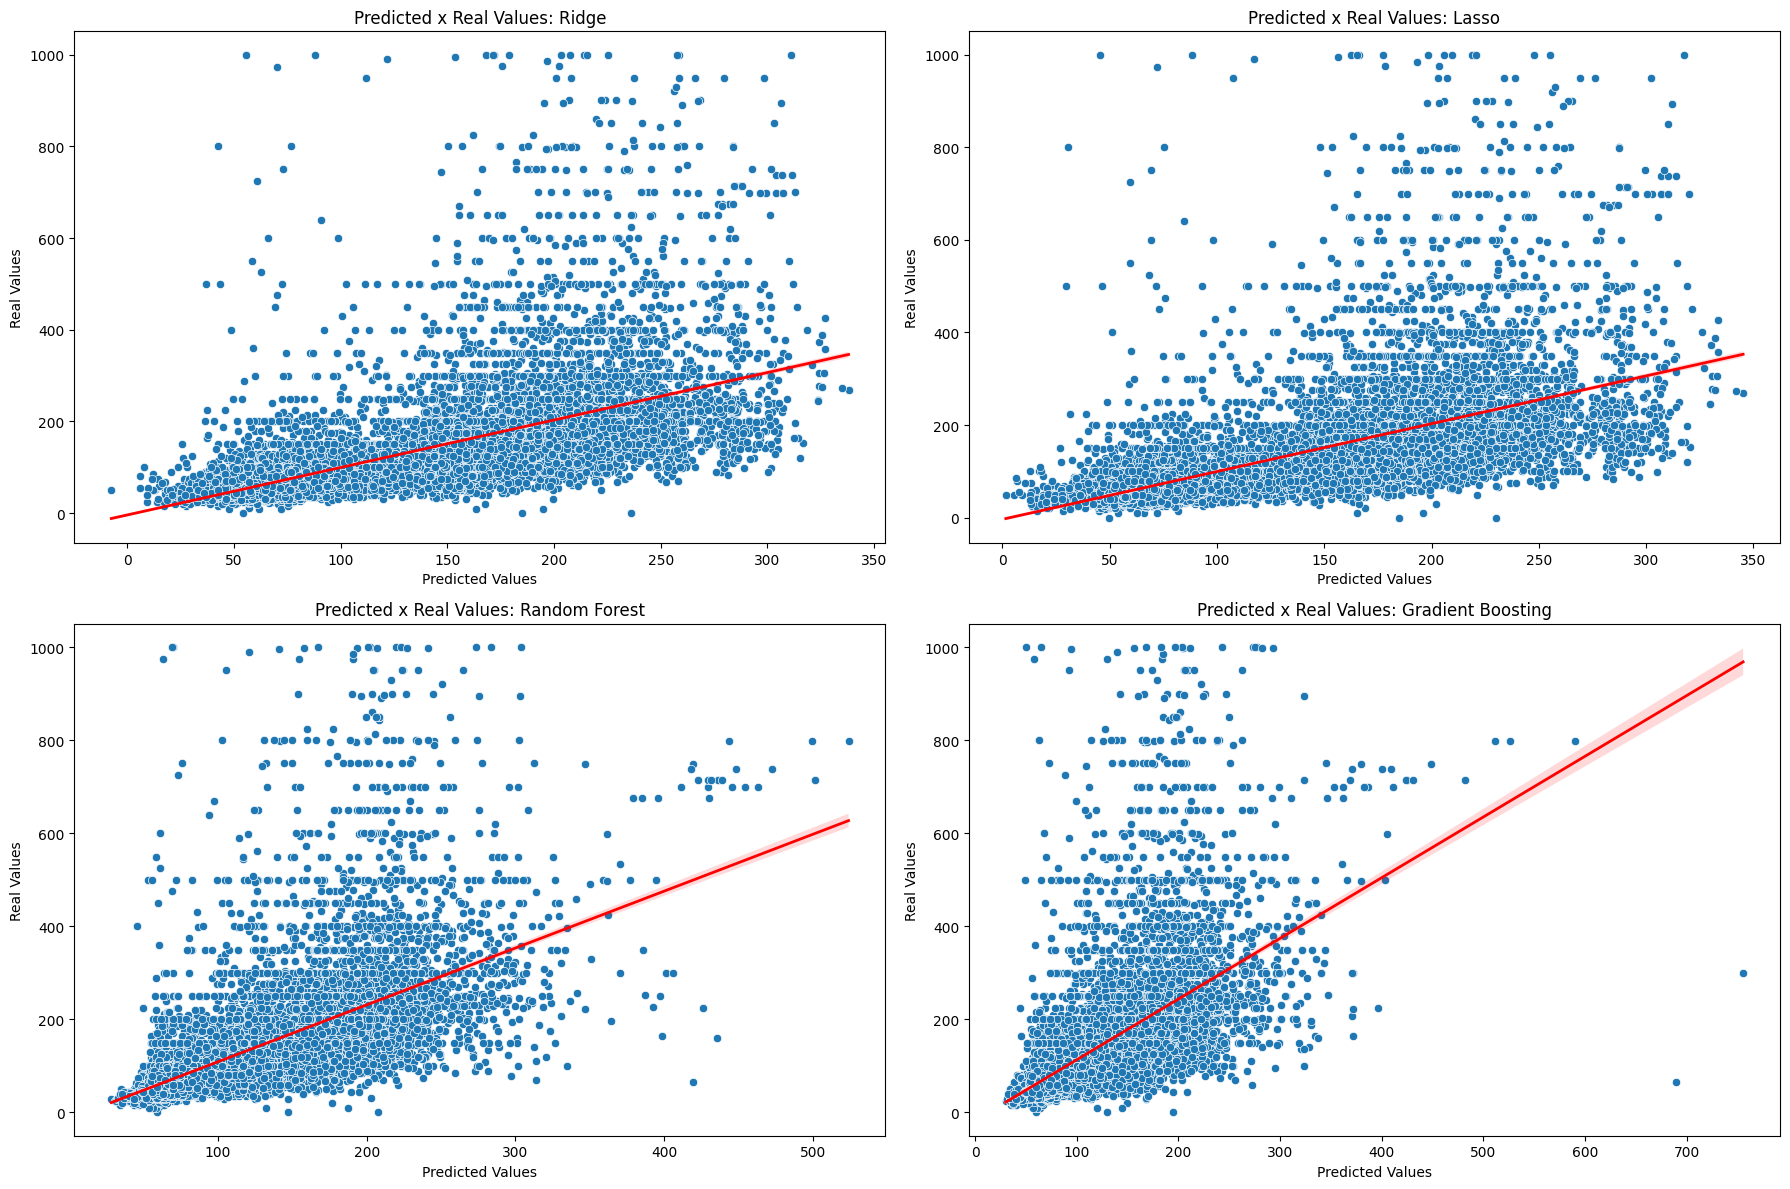

In [18]:
metrics.plot_pred_x_real(y_test, 2, 2)

In [23]:
df_metrics = pd.DataFrame.from_dict(model_report, orient='index')
df_metrics.drop(columns=["model", "y_pred"])

,mae,rmse,r2
Ridge,54.698606,94.826049,0.345614
Lasso,54.860889,95.044669,0.342594
Random Forest,48.058575,92.484462,0.377534
Gradient Boosting,48.464160,94.977382,0.343524


### Observations:
- All models had a very similar performance, and all of them struggle to correctly predict prices that are too high, likely due to the fact that from prices of 400 dollars and up, there's only 3% of the total data
- Ridge and Lasso showed the same performance, with their regularization term being able to handle the non-linear relations
- The ensemble models had a small improvement on performance
- Ridge, Lasso and Gradient Boosting all had the same R² score, but the mean error of the ensemble model was way below the others
- Based on the metrics, the Random Forest model is the best one, with the lowest errors and the highest R² score

## Residual Analysis

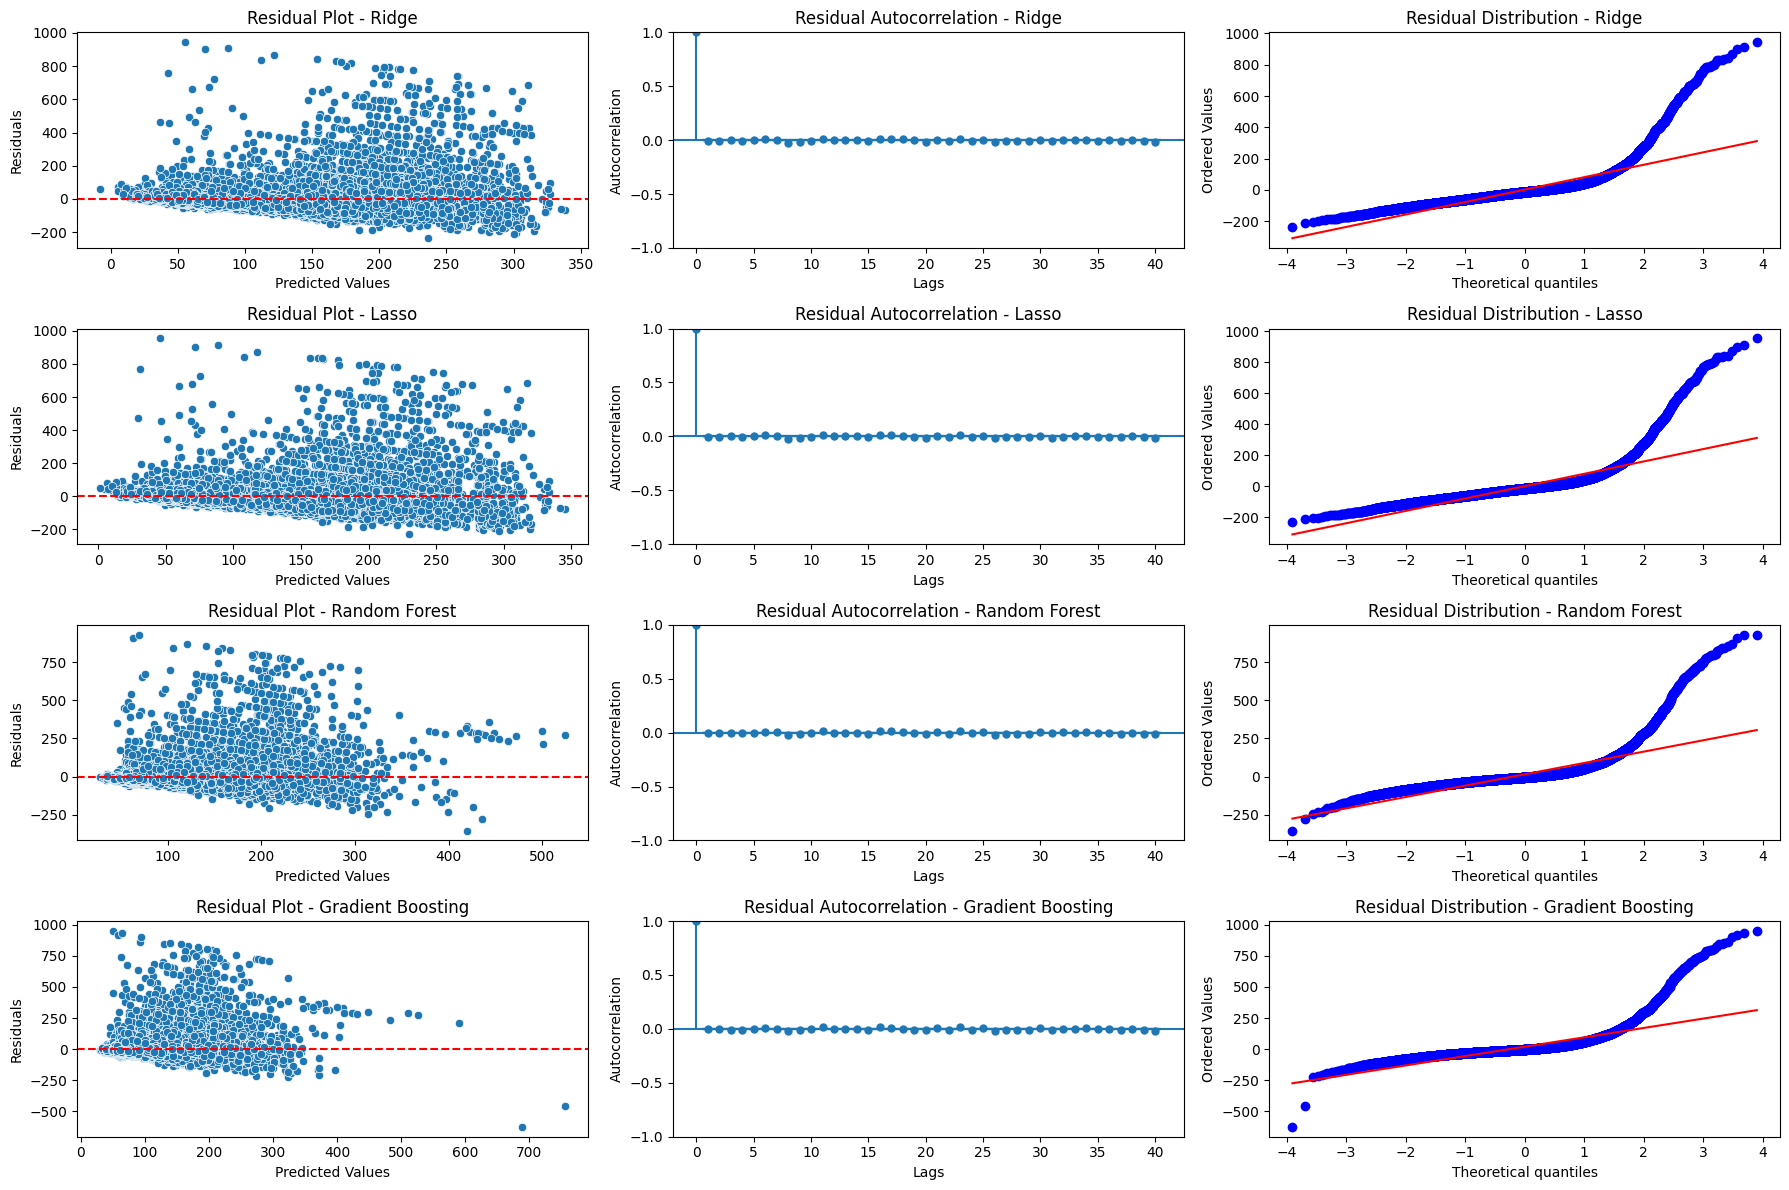

In [19]:
metrics.plot_residuals(y_test, 4, 3)

### Observations:
- The residuals of all models behave basically in the same way
- No model has autocorrelated residuals, indicating that the errors of the model are independent of each other, which can be considered a good thing, since this tends to show that the model has captured the pattern in the data, with only noise in the residuals
- Despite no autocorrelation, no model was able to have residuals with a normal distribution, indicating that no model is capturing the full variability of the data
- With a combination of non-normal residuals and low R² scores, is clear that no model was able to capture all non-linear relations between the data, and they are not ideal models, statistically speaking

## Feature Importance

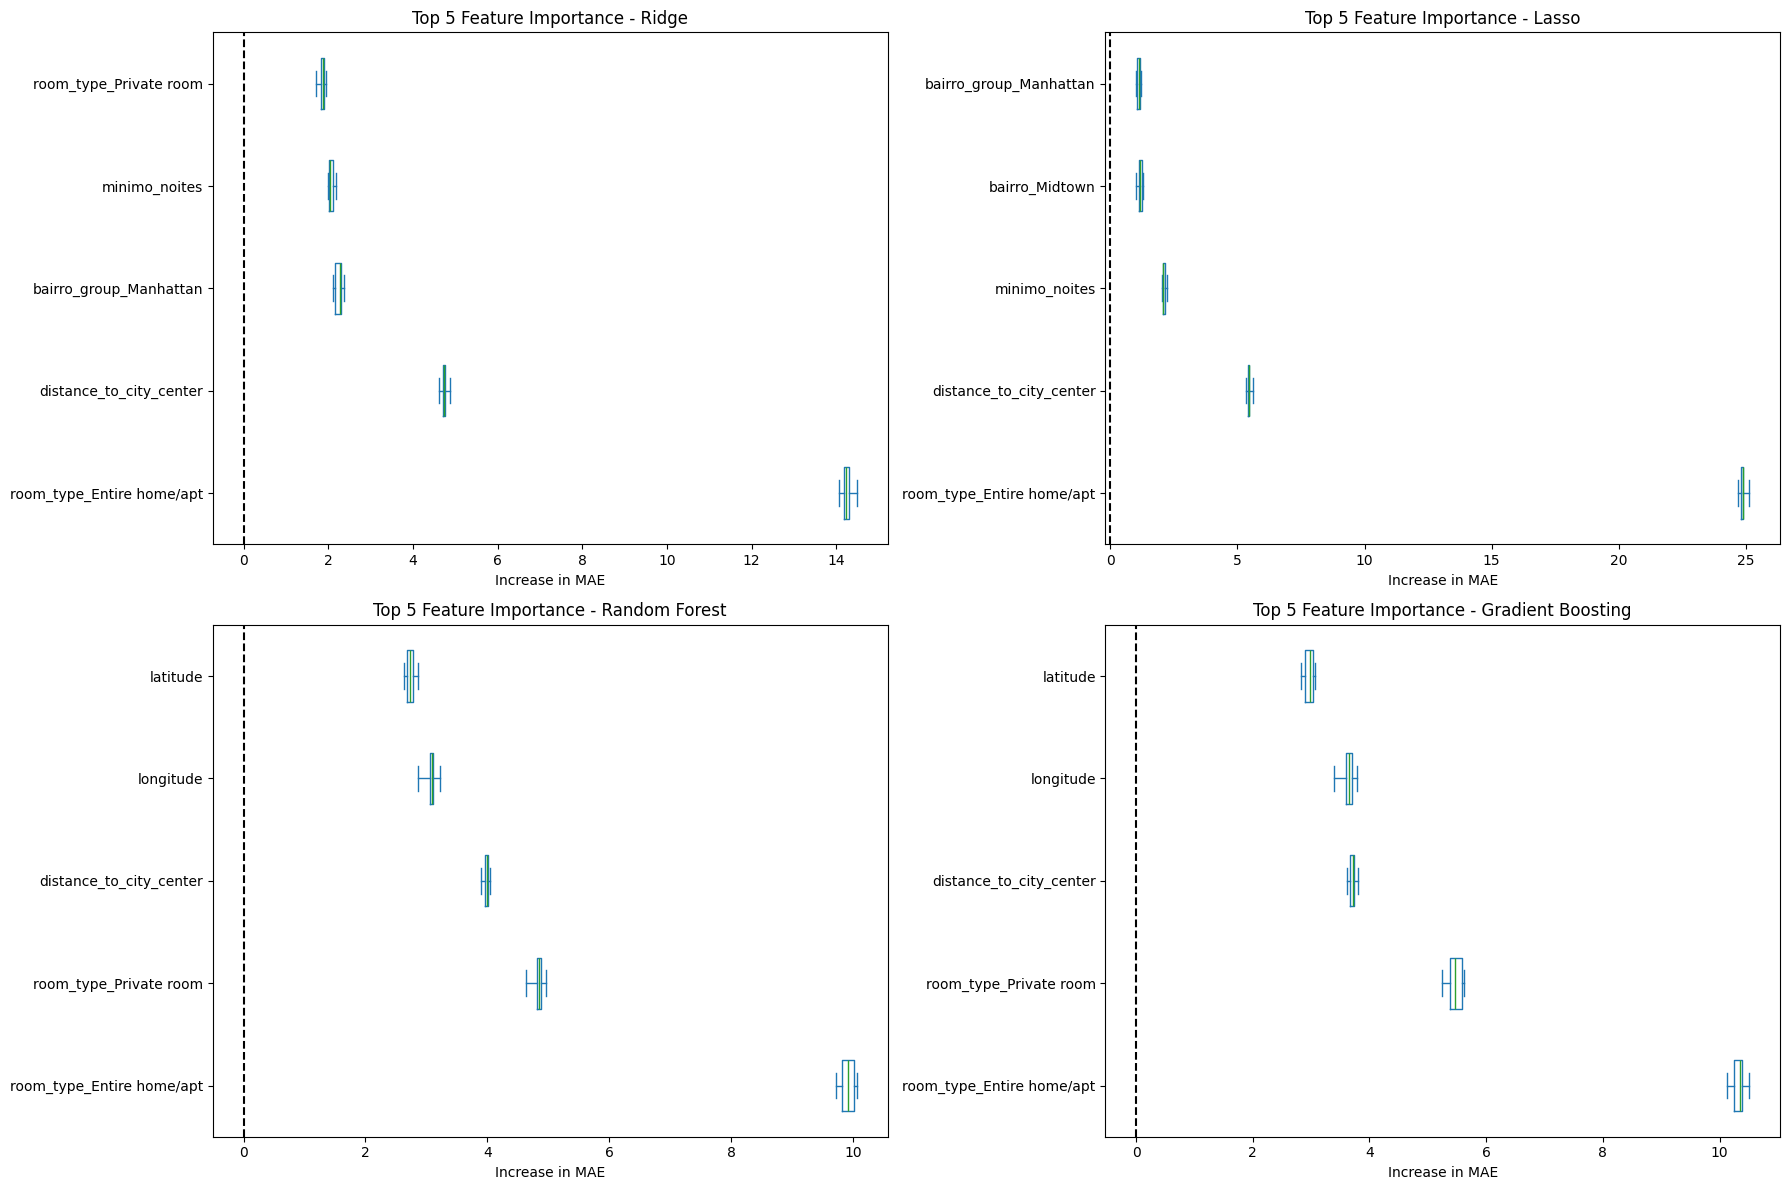

In [16]:
metrics.plot_feature_importance(y_test=y_test, X_test=X_test, metric="neg_mean_absolute_error", rows=2, columns=2)

### Observations:
- There's a clear difference in what features are most important for the two categories of models
- Ridge and Lasso both have location columns in their top 5 most important ones, with `minimo_noites` appearing in second and third place
- The ensemble models have the coordinates features as the most important ones, with the categories of `room_type` closing the list
- All models have the created feature `distance_to_city_center` in their top 5 most important features, this means that all models rely on the correct values of this feature to make predictions. When permutation is applied to this feature, the impact on **MAE** is very low, making this feature very important

## Conclusion

### All models had pretty similar results, with the ensemble ones having a way lower error. No model was considered ideal by the residual analysis, since there were no normally distributed residuals, which, combined with low R² scores, shows that no model was able to handle all non-linear relations between the data, nor was it able to capture the full variability of the data
### When looking at features importance, the engineered feature `distance_to_city_center` was the only one that appeared in the top 5 most important features of all models, rendering the feature engineering efforts a success
### Despite no model being considered ideal and the low R² scores, the best model in terms of metrics was the Random Forest one, with the lower **MAE** and **RSME**, and highest **R²**

# Loading and saving the best model

In [7]:
import mlflow
import pickle
uri = "https://dagshub.com/vitorccmanso/Rent-Price-Prediction.mlflow"

def load_model_from_mlflow(uri):
    mlflow.set_tracking_uri(uri)
    client = mlflow.tracking.MlflowClient(tracking_uri=uri)

    registered_model = client.get_registered_model('Random Forest - LH_CD_Vitor-Cunha')
    run_id = registered_model.latest_versions[-1].run_id
    logged_model = f'runs:/{run_id}/Random Forest'
    loaded_model = mlflow.sklearn.load_model(logged_model)

    with open('../artifacts/model.pkl', 'wb') as f:
        pickle.dump(loaded_model, f)

In [8]:
load_model_from_mlflow(uri)